In [1]:
# !pip install --upgrade timm

### **Library Imports**

In [2]:
import os
import re
import cv2
# import timm
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
# from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

### **Utilities and Constants**

In [3]:
SEED = 42
# SIZE = 384
# FV_LENGTH = 1536
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FEATURE_PATH = "../input/fgvc9-swinl38422k"

# CLASSIFIER_HEAD_PATH = "../input/fgvc9-swin38422k-train/saves"
# TRANSFORM = transforms.Compose([transforms.ToTensor(), 
#                                 transforms.Normalize([0.485, 0.456, 0.406], 
#                                                      [0.229, 0.224, 0.225]),
#                                ])

SAVE_PATH = "saves"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [4]:
def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

    
# def get_image(path: str, size: int) -> np.ndarray:
#     image = cv2.imread(path, cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
#     return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    
def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

### **Dataset Templatea**

In [5]:
# class FEDS(Dataset):
#     def __init__(self, base_path: str, filenames: np.ndarray, transform):
#         self.base_path = base_path
#         self.filenames = filenames
#         self.transform = transform
    
#     def __len__(self):
#         return self.filenames.shape[0]
    
#     def __getitem__(self, idx):
#         return self.transform(get_image(os.path.join(self.base_path, self.filenames[idx])))


class DS(Dataset):
    def __init__(self, X=None, y=None, mode="train"):
        self.mode = mode

        assert(re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE) or re.match(r"test", self.mode, re.IGNORECASE))

        self.X = X
        if re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE):
            self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if re.match(r"train", self.mode, re.IGNORECASE) or re.match(r"valid", self.mode, re.IGNORECASE):
            return torch.FloatTensor(self.X[idx]), torch.LongTensor(self.y[idx])
        else:
            return torch.FloatTensor(self.X[idx])

### **Model**

In [6]:
class Model(nn.Module):
    def __init__(self, IL: int=None, HL: list=None, DP: float=None, use_WN: bool=False):
        super(Model, self).__init__()

        self.model = nn.Sequential()

        if len(HL) == 1:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN: 
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else: 
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN: 
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=100)))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=100))

        
        elif len(HL) == 2:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN: 
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else: 
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.model.add_module("DP2", nn.Dropout(p=DP))
            self.model.add_module("AN2", nn.ReLU())
            self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
            if use_WN: 
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=100)))
            else:
                self.model.add_module("FC3", nn.Linear(in_features=HL[1], out_features=100))
        
        elif len(HL) == 3:
            self.model.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            if use_WN: 
                self.model.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
            else: 
                self.model.add_module("FC1", nn.Linear(in_features=IL, out_features=HL[0]))
            if isinstance(DP, float):
                self.model.add_module("DP1", nn.Dropout(p=DP))
            self.model.add_module("AN1", nn.ReLU())
            self.model.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
            if use_WN:
                self.model.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
            else:
                self.model.add_module("FC2", nn.Linear(in_features=HL[0], out_features=HL[1]))
            if isinstance(DP, float):
                self.model.add_module("DP2", nn.Dropout(p=DP))
            self.model.add_module("AN2", nn.ReLU())
            self.model.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
            if use_WN:
                self.model.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=HL[2])))
            else:
                self.model.add_module("FC3", nn.Linear(in_features=HL[1], out_features=HL[2]))
            if isinstance(DP, float):
                self.model.add_module("DP3", nn.Dropout(p=DP))
            self.model.add_module("AN3", nn.ReLU())
            self.model.add_module("BN4", nn.BatchNorm1d(num_features=HL[2], eps=1e-5))
            if use_WN: 
                self.model.add_module("FC4", WN(nn.Linear(in_features=HL[2], out_features=100)))
            else:
                self.model.add_module("FC4", nn.Linear(in_features=HL[2], out_features=100))
    
    def get_optimizer(self, lr=1e-3, wd=0.0):
        return optim.SGD(self.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

    def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps)
    
    def forward(self, x):
        return nn.LogSoftmax(dim=1)(self.model(x))

### **Fit and Predict Helper**

In [7]:
def fit(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None, dataloaders=None, fold=None, verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        print(f"Training Fold {fold}...")
        breaker()
        
    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, Accuracies = [], []
    name = f"state_fold_{fold}.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []
            
            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           os.path.join(SAVE_PATH, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict" : model.state_dict(),
                        "optim_state_dict" : optimizer.state_dict()},
                        os.path.join(SAVE_PATH, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
        
        if scheduler:
            # scheduler.step(epochLoss["valid"])
            scheduler.step()
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, BLE, BAE, name


# def predict(model=None, dataloader=None, path=None) -> np.ndarray:
#     model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
#     model.to(DEVICE)    
#     model.eval()
    
#     y_pred = torch.zeros(1, 1).to(DEVICE)
    
#     for X in dataloader:
#         X = X.to(DEVICE)
#         with torch.no_grad():
#             output = torch.argmax(torch.exp(model(X)), dim=1)
#         y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
#     return y_pred[1:].detach().cpu().numpy()

### **Load Data**

In [8]:
features = np.load(os.path.join(FEATURE_PATH, "features.npy"))
labels   = np.load(os.path.join(FEATURE_PATH, "labels.npy"))

### **Params**

In [9]:
DEBUG: bool = False
    
if DEBUG:
    n_splits = 3
    epochs = 2
    HL = [4]
else:
    n_splits = 5
    epochs = 500
    HL = [2048, 1024, 512]

batch_size = 1024
lr = 1e-4
wd = 1e-5
early_stopping = 25
patience = None
eps = None

### **Train**


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 4.77193 | Valid Loss: 4.61866 |Train Accs: 0.01073 | Valid Accs: 0.01014 | Time: 10.87 seconds
Epoch: 2 | Train Loss: 4.76892 | Valid Loss: 4.62895 |Train Accs: 0.00944 | Valid Accs: 0.01073 | Time: 9.99 seconds
Epoch: 3 | Train Loss: 4.76151 | Valid Loss: 4.63128 |Train Accs: 0.00938 | Valid Accs: 0.00917 | Time: 9.96 seconds
Epoch: 4 | Train Loss: 4.77589 | Valid Loss: 4.63155 |Train Accs: 0.01046 | Valid Accs: 0.00956 | Time: 10.33 seconds
Epoch: 5 | Train Loss: 4.76744 | Valid Loss: 4.63171 |Train Accs: 0.01112 | Valid Accs: 0.01054 | Time: 10.11 seconds
Epoch: 6 | Train Loss: 4.76139 | Valid Loss: 4.63152 |Train Accs: 0.01105 | Valid Accs: 0.00937 | Time: 9.87 seconds
Epoch: 7 | Train Loss: 4.77501 | Valid Loss: 4.63136 |Train Accs: 0.01003 | Valid Accs: 0.00956 | Time: 10.30 seconds
Epoch: 8 | Train Loss: 4.76927 | Valid Loss: 4.63160

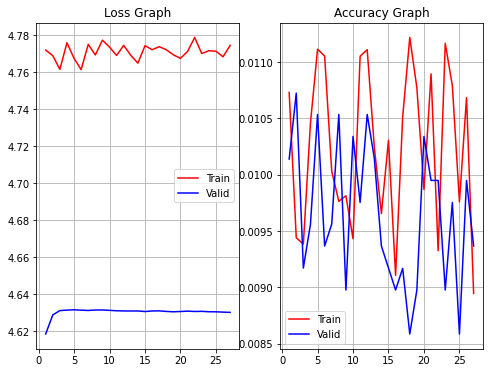


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 4.77135 | Valid Loss: 4.61684 |Train Accs: 0.01063 | Valid Accs: 0.01034 | Time: 9.89 seconds
Epoch: 2 | Train Loss: 4.77139 | Valid Loss: 4.62696 |Train Accs: 0.00981 | Valid Accs: 0.01170 | Time: 10.22 seconds
Epoch: 3 | Train Loss: 4.77320 | Valid Loss: 4.62904 |Train Accs: 0.01046 | Valid Accs: 0.01151 | Time: 10.01 seconds
Epoch: 4 | Train Loss: 4.77001 | Valid Loss: 4.62936 |Train Accs: 0.01138 | Valid Accs: 0.01190 | Time: 9.81 seconds
Epoch: 5 | Train Loss: 4.77631 | Valid Loss: 4.62941 |Train Accs: 0.01084 | Valid Accs: 0.01112 | Time: 9.76 seconds
Epoch: 6 | Train Loss: 4.77653 | Valid Loss: 4.62888 |Train Accs: 0.01100 | Valid Accs: 0.01112 | Time: 10.23 seconds
Epoch: 7 | Train Loss: 4.77128 | Valid Loss: 4.62934 |Train Accs: 0.01089 | Valid Accs: 0.01190 | Time: 9.98 seconds
Epoch: 8 | Train Loss: 4.77060 | Valid Loss: 4.62927 

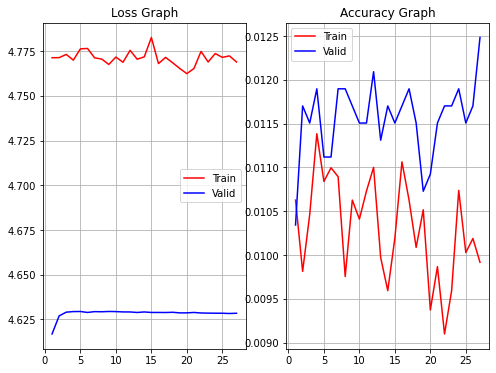


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 4.77079 | Valid Loss: 4.61843 |Train Accs: 0.00987 | Valid Accs: 0.01035 | Time: 10.25 seconds
Epoch: 2 | Train Loss: 4.76909 | Valid Loss: 4.62767 |Train Accs: 0.00910 | Valid Accs: 0.01073 | Time: 9.55 seconds
Epoch: 3 | Train Loss: 4.76982 | Valid Loss: 4.62973 |Train Accs: 0.00949 | Valid Accs: 0.01014 | Time: 9.54 seconds
Epoch: 4 | Train Loss: 4.77176 | Valid Loss: 4.63013 |Train Accs: 0.01008 | Valid Accs: 0.01092 | Time: 10.18 seconds
Epoch: 5 | Train Loss: 4.77119 | Valid Loss: 4.62995 |Train Accs: 0.00998 | Valid Accs: 0.00995 | Time: 10.27 seconds
Epoch: 6 | Train Loss: 4.77439 | Valid Loss: 4.63009 |Train Accs: 0.01008 | Valid Accs: 0.01112 | Time: 11.04 seconds
Epoch: 7 | Train Loss: 4.77432 | Valid Loss: 4.62986 |Train Accs: 0.00965 | Valid Accs: 0.01073 | Time: 10.11 seconds
Epoch: 8 | Train Loss: 4.76875 | Valid Loss: 4.6300

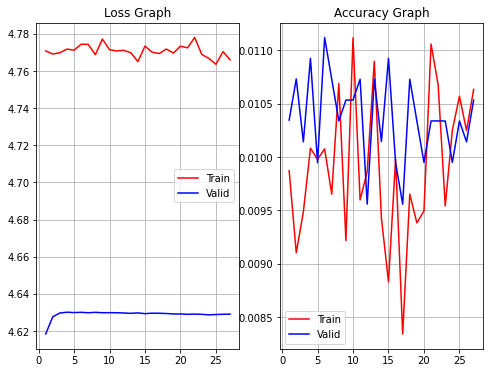


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 4.77737 | Valid Loss: 4.61374 |Train Accs: 0.01040 | Valid Accs: 0.01347 | Time: 9.60 seconds
Epoch: 2 | Train Loss: 4.77479 | Valid Loss: 4.62203 |Train Accs: 0.00949 | Valid Accs: 0.01698 | Time: 8.76 seconds
Epoch: 3 | Train Loss: 4.77247 | Valid Loss: 4.62399 |Train Accs: 0.00955 | Valid Accs: 0.01581 | Time: 8.81 seconds
Epoch: 4 | Train Loss: 4.77189 | Valid Loss: 4.62427 |Train Accs: 0.00970 | Valid Accs: 0.01601 | Time: 9.35 seconds
Epoch: 5 | Train Loss: 4.77275 | Valid Loss: 4.62388 |Train Accs: 0.00949 | Valid Accs: 0.01698 | Time: 8.76 seconds
Epoch: 6 | Train Loss: 4.77155 | Valid Loss: 4.62419 |Train Accs: 0.00970 | Valid Accs: 0.01640 | Time: 8.80 seconds
Epoch: 7 | Train Loss: 4.77254 | Valid Loss: 4.62416 |Train Accs: 0.00933 | Valid Accs: 0.01581 | Time: 9.18 seconds
Epoch: 8 | Train Loss: 4.77344 | Valid Loss: 4.62386 |Tr

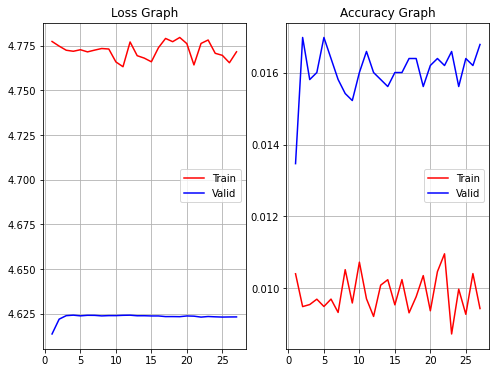


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 4.77462 | Valid Loss: 4.61412 |Train Accs: 0.00889 | Valid Accs: 0.01308 | Time: 9.42 seconds
Epoch: 2 | Train Loss: 4.77028 | Valid Loss: 4.62312 |Train Accs: 0.01036 | Valid Accs: 0.01250 | Time: 9.68 seconds
Epoch: 3 | Train Loss: 4.78323 | Valid Loss: 4.62566 |Train Accs: 0.00965 | Valid Accs: 0.01230 | Time: 9.20 seconds
Epoch: 4 | Train Loss: 4.76790 | Valid Loss: 4.62628 |Train Accs: 0.00884 | Valid Accs: 0.01172 | Time: 8.84 seconds
Epoch: 5 | Train Loss: 4.77120 | Valid Loss: 4.62601 |Train Accs: 0.00954 | Valid Accs: 0.01211 | Time: 9.48 seconds
Epoch: 6 | Train Loss: 4.76789 | Valid Loss: 4.62598 |Train Accs: 0.01013 | Valid Accs: 0.01191 | Time: 8.92 seconds
Epoch: 7 | Train Loss: 4.77113 | Valid Loss: 4.62618 |Train Accs: 0.00884 | Valid Accs: 0.01211 | Time: 8.84 seconds
Epoch: 8 | Train Loss: 4.76923 | Valid Loss: 4.62587 |Tr

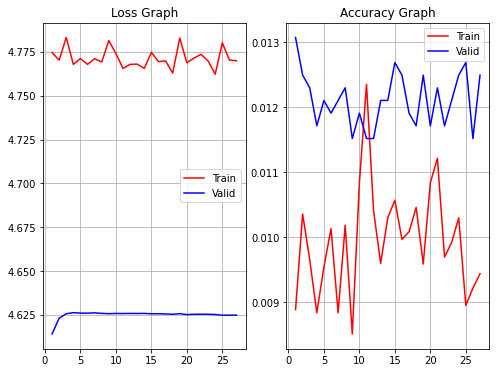


**************************************************

Total Time Taken for 5-Fold CV : 21.59 minutes

**************************************************



In [10]:
fold = 1

start_time = time()
for tr_idx, va_idx in StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True).split(features, labels):
    tr_features, va_features, tr_labels, va_labels = features[tr_idx], features[va_idx], labels[tr_idx], labels[va_idx]
    
    tr_data_setup = DS(tr_features, tr_labels.reshape(-1, 1), "train")
    va_data_setup = DS(va_features, va_labels.reshape(-1, 1), "valid")

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(SEED)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False),
    }

    torch.manual_seed(SEED)
    model = Model(IL=tr_features.shape[1], HL=HL, DP=0.5, use_WN=True).to(DEVICE)
    optimizer = model.get_optimizer(lr=lr, wd=wd)
    # scheduler = None
    # if isinstance(patience, int) and isinstance(eps, float):
    #    scheduler = get_plateau_scheduler(optimizer=optimizer, patience=patience, eps=eps)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, 
                                              epochs=epochs, steps_per_epoch=len(dataloaders["train"]),
                                              pct_start=0.2, div_factor=1e3, final_div_factor=1e3)
    
    L, A, BLE, BAE, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                           epochs=epochs, early_stopping_patience=early_stopping, 
                           dataloaders=dataloaders, fold=fold, verbose=True)

    breaker()
    show_graphs(L, A)
    fold += 1

breaker()
print(f"Total Time Taken for {n_splits}-Fold CV : {(time()-start_time)/60:.2f} minutes")
breaker()

### **Get SWIN Features for the Test Set**

In [11]:
# train_df = pd.read_csv("../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv")
# ss_df = pd.read_csv("../input/sorghum-id-fgvc-9/sample_submission.csv")

# broken_images = [filename for filename in train_df.image if filename not in os.listdir("../input/sorghum-id-fgvc-9/train_images")]
# for broken_image in broken_images:
#     index = train_df.index[train_df.image == broken_image]
#     train_df = train_df.drop(index=index)
    
# filenames = train_df.image.copy().values
# labels    = train_df.cultivar.copy().values 

# labels = le.fit_transform(labels)

# ts_filenames = ss_df.filename.copy().values
# ts_features = np.zeros((len(ts_filenames), FV_LENGTH))

In [12]:
# model = timm.create_model("swin_base_patch4_window7_384_in22k", pretrained=True).to(DEVICE)
# model = torch.nn.Sequential(*[*model.children()][:-3])

# dataloader_setup = FEDS("../input/sorghum-id-fgvc-9/test", ts_filenames, TRANSFORM)
# dataloader = DL(dataloader_setup, batch_size=64, shuffle=False)

# ts_features = torch.zeros(1, FV_LENGTH).to(DEVICE)

# for X in dataloader:
#     X = X.to(DEVICE)
#     with torch.no_grad():
#         output = model(X).last_hidden_state
#     ts_features = torch.cat((ts_features, output[:, 0, :]), dim=0)

# ts_features = ts_features[1:].detach().cpu().numpy()

### **Submission**

In [13]:
# ts_data_setup = DS(ts_features, None, "test")
# ts_data = DL(ts_data_setup, batch_size=batch_size, shuffle=False)

# torch.manual_seed(SEED)
# model = Model(IL=ts_features.shape[1], HL=HL, DP=0.5, use_WN=True).to(DEVICE)

# best_model_fold = _____
# y_pred = predict(model=model, dataloader=ts_data, path=os.path.join(CLASSIFIER_HEAD_PATH, f"state_fold_{best_model_fold}.pt"))

# ss_df["cultivar"] = le.inverse_transform(y_pred.astype("uint8"))
# ss_df.to_csv("submission.csv", index=False)